In [69]:
import numpy as np 
import pandas as pd 
import os
from joblib import Parallel, delayed
import SimpleITK as sitk
from scipy import ndimage
from skimage import measure
import matplotlib.pyplot as plt
%matplotlib inline

import dicom
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.util.shape import view_as_windows


In [63]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, _, _ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [14]:
# contains LIDC radiologist annotations for the LUNA16 nodules.
PATH = '../../data/'
df = pd.read_csv(PATH + 'CSVFILES/annotations_enhanced.csv')
print (df.shape)
df.head()

(1172, 23)


,seriesuid,coordX,coordY,coordZ,diameter_mm,Xorig,Yorig,Zorig,Xspac,Yspac,...,Znpy,subtlety,internal_structure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348,-170.687500,-309.687500,716.7,0.625000,0.625000,...,88.708056,3.333333,[ 1. 0. 0. 0.],[ 0. 0. 0. 0. 0. 1.],[ 0. 1. 0.],3.666667,1.333333,1.333333,[ 0. 0. 1.],2.666667
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262,-120.049467,9.480416,-657.0,0.556641,0.556641,...,265.918724,4.500000,[ 1. 0. 0. 0.],[ 0. 0. 0. 0. 0. 1.],[ 0. 1. 0.],4.750000,1.750000,1.500000,[ 0. 0. 1.],3.750000
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150,-120.049467,9.480416,-657.0,0.556641,0.556641,...,251.506268,5.000000,[ 1. 0. 0. 0.],[ 0. 0. 0. 0. 0. 1.],[ 0. 0.25 0.75],4.750000,1.750000,1.500000,[ 0. 0. 1.],4.250000
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,90.931713,149.027266,-426.544715,18.208570,-120.049467,9.480416,-657.0,0.556641,0.556641,...,230.455285,5.000000,[ 1. 0. 0. 0.],[ 0. 0. 0. 0. 0. 1.],[ 0. 0.5 0.5],5.000000,1.750000,1.250000,[ 0. 0. 1.],3.750000
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,89.540769,196.405159,-515.073322,16.381276,-120.049467,9.480416,-657.0,0.556641,0.556641,...,141.926678,4.750000,[ 1. 0. 0. 0.],[ 0. 0. 0. 0. 0. 1.],[ 0. 0.25 0.75],4.250000,1.500000,1.500000,[ 0. 0.5 0.5],3.750000


In [15]:
df.columns

Index(['seriesuid', 'coordX', 'coordY', 'coordZ', 'diameter_mm', 'Xorig',
       'Yorig', 'Zorig', 'Xspac', 'Yspac', 'Zspac', 'Xnpy', 'Ynpy', 'Znpy',
       'subtlety', 'internal_structure', 'calcification', 'sphericity',
       'margin', 'lobulation', 'spiculation', 'texture', 'malignancy'],
      dtype='object')

# voxels_true32

[827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827
 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827 827
 827 827 827 827 827 827 827 827 827 827 827 827 141 141]
(3216, 32, 32, 32)


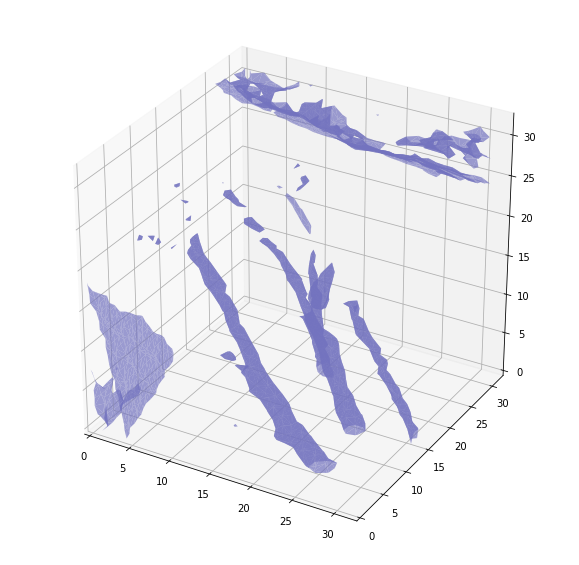

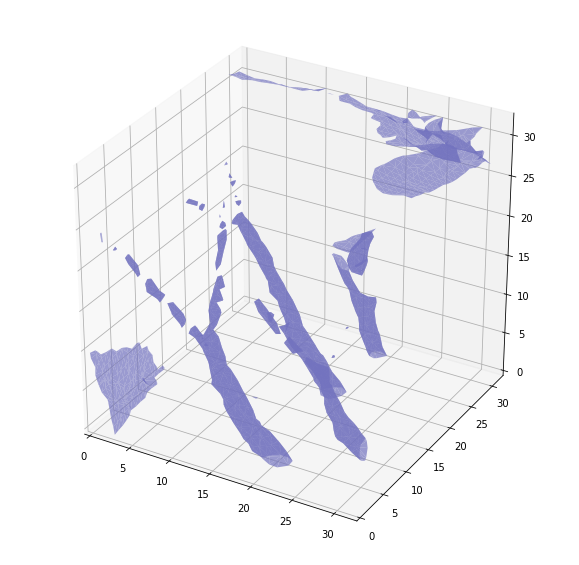

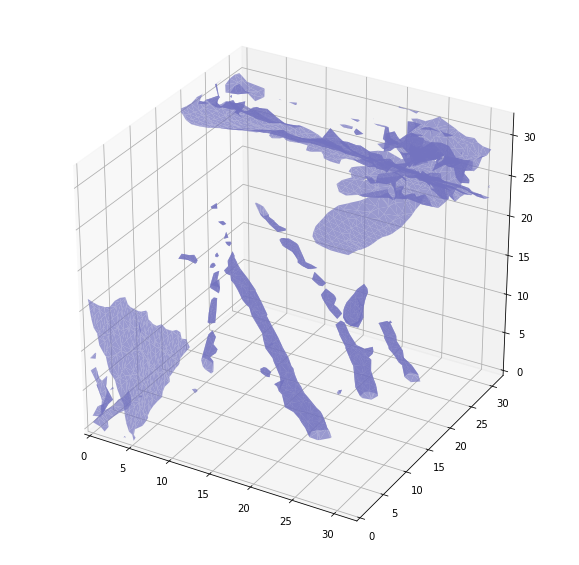

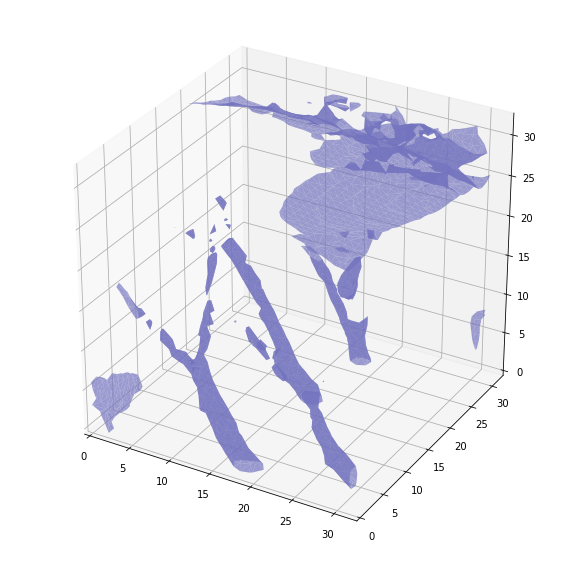

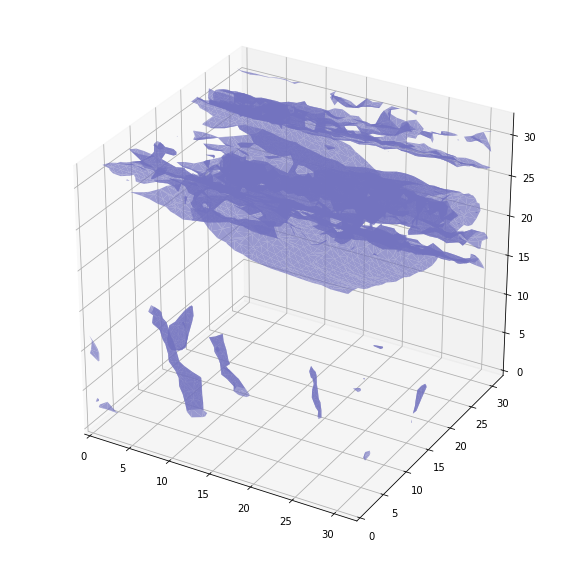

In [84]:
# index
index_vox_true = np.load(PATH + 'voxels_true32/subset0IXtrue.npy')
print (index_vox_true[:50])

# voxels
vox_true = np.load(PATH + 'voxels_true32/subset0Xtrue.npy')
print (vox_true.shape)
patient1 = vox_true[0,:,:,:]

# plots
for i in range(5):
    plot_3d(vox_true[i,:,:,:],0)

# voxels_false32

<font color="red"> the shape seems to be wrong </font>

[-2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
 -2 -2 -2 -2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
(1068, 64, 64, 64)


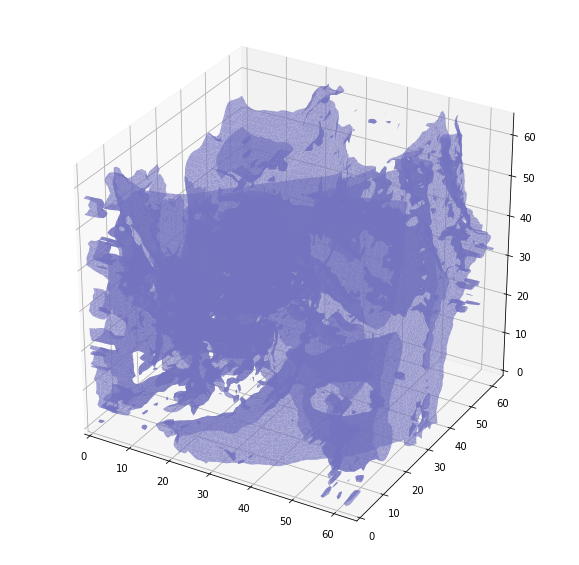

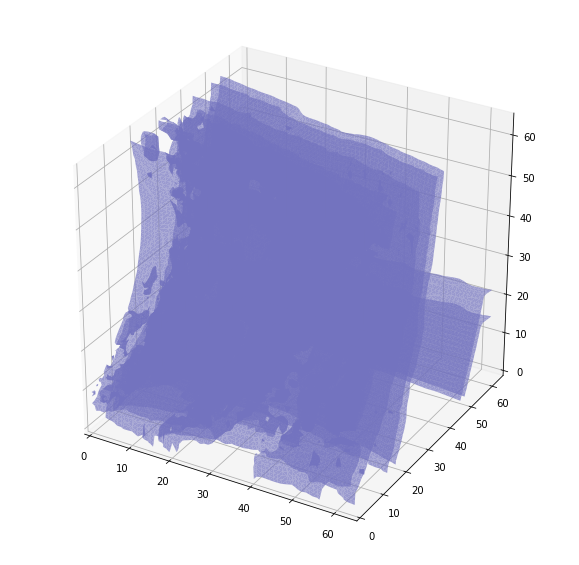

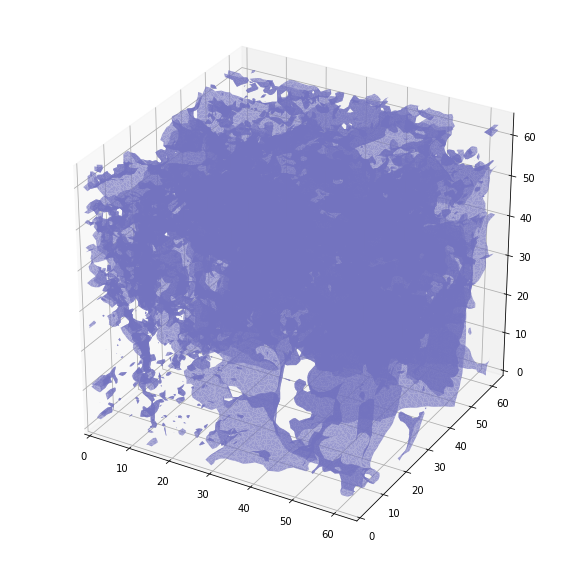

In [85]:
index_vox_false = np.load(PATH + 'voxels_false32/subset0IXfalse.npy')
print (index_vox_false[:50])

vox_false = np.load(PATH + 'voxels_false32/subset0Xfalse.npy')
print (vox_false.shape)
patient1 = vox_false[0,:,:,:]

for i in range(3):
    plot_3d(vox_false[i,:,:,:],0)

[-2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2
 -2 -2 -2 -2 -2 -2 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
(1068, 64, 64, 64)


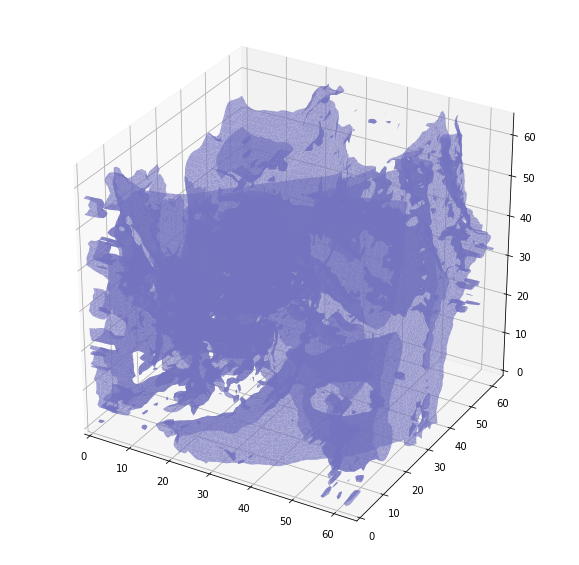

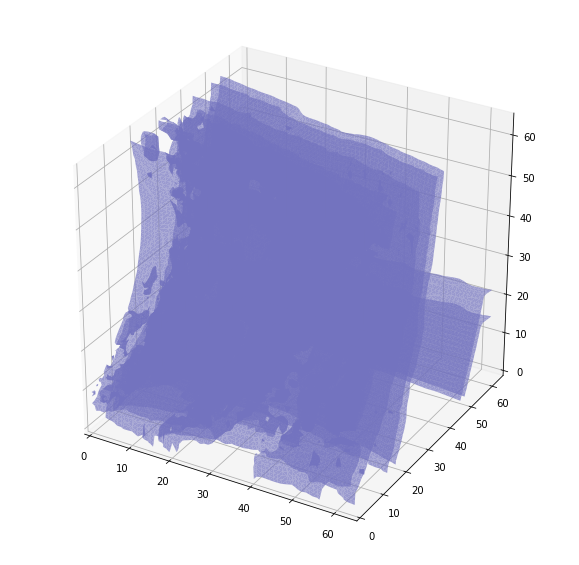

In [87]:
index_vox_false = np.load(PATH + 'voxels_false64/subset0IXfalse.npy')
print (index_vox_false[:50])

vox_false = np.load(PATH + 'voxels_false64/subset0Xfalse.npy')
print (vox_false.shape)
patient1 = vox_false[0,:,:,:]

for i in range(2):
    plot_3d(vox_false[i,:,:,:],0)

# voxels_random32

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(4272, 32, 32, 32)


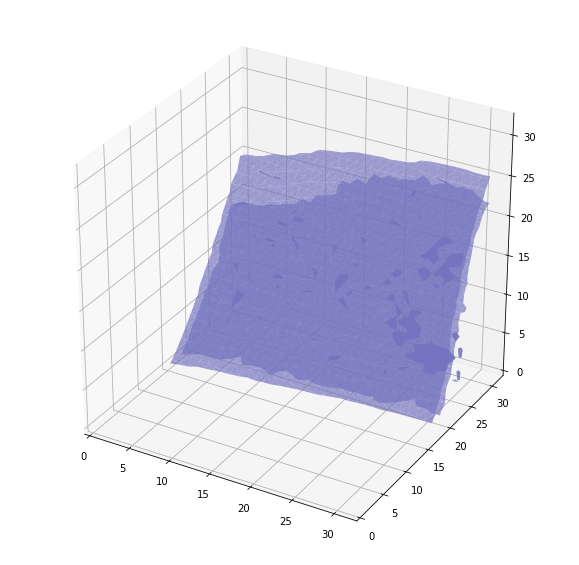

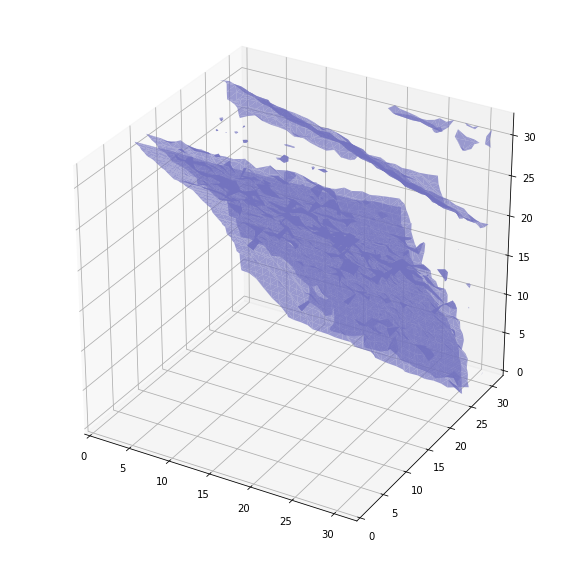

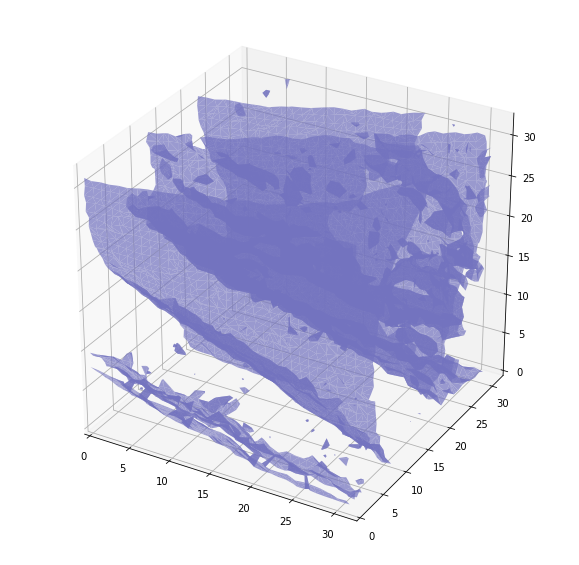

In [86]:
index_vox_random = np.load(PATH + 'voxels_random32/subset0IXrandom.npy')
print (index_vox_random[:50])

vox_random = np.load(PATH + 'voxels_random32/subset0Xrandom.npy')
print (vox_random.shape)
patient1 = vox_random[0,:,:,:]

for i in range(3):
    plot_3d(vox_random[i,:,:,:],0)